# How to Request OOI Data
By Sage Lichtenwalner, May 5, 2020

In this notebook, I will demonstrate how to request and load data from the [OOI Data Portal](https://ooinet.oceanobservatories.org).  The process is rather striaghtforward, which is good, because the dataset under the hood is quite complex.  

Thankfully, with a few customized functions, we can easily repeat this process to request data from almost all of the instruments available from the OOI.  If you'd like to see these functions in action on a variety of instrument types, check out the [data-lab-workshops](https://github.com/ooi-data-lab/data-lab-workshops) repo.

## Introduction

Requesting data using the Data Portal API is essentially a 3-step process:

1. Request your dataset, by specifying an instrument and timeframe
2. Build a list of available data files
3. Load in your dataset

Note, unlike many data portals where you simply request data from a pre-processed dataset, the OOI data portal actually generates a customized dataset for you.  That means when you request a dataset (step 1) you will receive a URL to a dataset directory that is specific to your request (i.e. it will only contain data from the instrument and timeframe you requested).  This *on demand* nature of the OOI data portal is by design (though its utility is debatable).  

The good news is, this process isn't that hard to work with, and it's the same regardless of the instrument type (profiler, fixed-depth, glider, node, etc.) you're interested in.

In [11]:
# Notebook setup
import requests
import os
import re

import xarray as xr
!pip install netcdf4

import matplotlib.pyplot as plt

# Setup default plot styles
import seaborn as sns
sns.set()

## Step 1 - Request Data
The trickiest part of this step is figuring out the [Reference Designator](https://oceanobservatories.org/knowledgebase/how-to-decipher-a-reference-designator/), [method and stream name](https://oceanobservatories.org/knowledgebase/understanding-data-streams-and-parameters/) you need for the dataset you're interested in.  

Once you have that, you can use this function to make your request.

Note, that the start_date and end_date are optional, but if you leave them out, the data system will retrieve ALL data available for your instrument.  In many cases there is over 5+ years of data, and this can result in a large dataset that you may not need, and if you try to load it all at once, you may have trouble with your notebook.

In [0]:
def request_data(reference_designator,method,stream,start_date=None,end_date=None):
  site = reference_designator[:8]
  node = reference_designator[9:14]
  instrument = reference_designator[15:]
  
  # Create the request URL
  api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
  data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

  # All of the following are optional, but you should specify a date range
  params = {
    'format':'application/netcdf',
    'include_provenance':'true',
    'include_annotations':'true'
  }
  if (start_date):
    params['beginDT'] = start_date
  if (end_date):
    params['endDT'] = end_date

  # Make the data request
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  
  if 'allURLs' in data:
    # All good, return just the THREDDS URL
    return data['allURLs'][0]
  else:
   print('Error: %s %s' % (data['message']['code'],data['message']['status']))

In order to run this function, we need to specify our API username and token which you can find on your profile page in the [OOI Data Portal](https://ooinet.oceanobservatories.org).

In [0]:
API_USERNAME = ''
API_TOKEN = ''


Now we can run our request function.  Keep in mind we only need to run this function once, which is why I like to keep it commented out until I really want it to run.  This keeps me from accidentally running it when rerunning a full notebook.

Note that if you specify one or both of the time inputs, they must be in the format `2019-01-01T00:00:00.000Z` or else you will get an error.

In [0]:
# Data Request - Comment out after running
# request_data('CP01CNSM-SBD11-06-METBKA000','telemetered','metbk_a_dcl_instrument',
#              '2019-01-01T00:00:00.000Z','2020-05-06T00:00:00.000Z')

The result of this function will be a URL to the directory that contains your data.  You should save this URL in your script (i.e. copy and paste it) so you do not need to run the request function again.  Doing so will generate a duplicate copy of the dataset on the server.

If you happen to misplace the URL, it should also be sent to you via email.

In [0]:
data_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200505T154746379Z-CP01CNSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/catalog.html'

## Step 2 - Build a list of files
If you look at the directory you get back from the OOI Data Portal, you will see that it includes a lot of files.  By design, data system will break up datasets into at least 1 file per deployment, and more if those files are over about 500MB.  In addition, the directory will contain many files that we don't need, including provenance files, annotations, and data files from dependent instruments.

Luckily, the following function will go through the directory and filter out just the files we need to load the dataset.

In [0]:
def get_data(url):
  '''Function to grab all data from specified directory'''
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous data files if necessary
  catalog_rms = url.split('/')[-2][20:]
  selected_datasets = []
  for d in datasets:
    if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
      selected_datasets.append(d + '#fillmismatch') # Add #fillmismatch to the URL to deal with a bug
  selected_datasets = sorted(selected_datasets)
  return selected_datasets 

In [17]:
datalist = get_data(data_url)
datalist

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sage@marine.rutgers.edu/20200505T154746379Z-CP01CNSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/deployment0010_CP01CNSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument_20190101T000053.889000-20190407T180303.666000.nc#fillmismatch',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sage@marine.rutgers.edu/20200505T154746379Z-CP01CNSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/deployment0011_CP01CNSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument_20190406T143543.898000-20190926T150508.413000.nc#fillmismatch',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sage@marine.rutgers.edu/20200505T154746379Z-CP01CNSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/deployment0012_CP01CNSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument_20190927T183031.398000-20200505T120424.194000.nc#fillmismatch']

## Step 3 - Load the dataset and profit
Finally, we have a list of netcdf data files for our desired instrument, which we can easily pass into xarray.open_mfdataset().

Depending on how large our dataset is, it may take some time for the dataset to load.  Keep in mind that xarray uses *lazy loading,* that is, your data won't be loaded into memory when you run the open_mfdataset() command.  Rather that will just create an index to the dataset on the server.  The data won't be loaded until it's needed, like when you run a plot(), mean() or load() command.

In [18]:
# Load in dataset
ds = xr.open_mfdataset(datalist)

# Becuase of a quirk of the OOI, we also want to swap the primary dimension
ds = ds.swap_dims({'obs': 'time'})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [19]:
# Print a list of variables
ds.data_vars

Data variables:
    met_heatflx_minute                    (time) float64 dask.array<chunksize=(139320,), meta=np.ndarray>
    met_current_direction_qc_results      (time) float32 dask.array<chunksize=(139320,), meta=np.ndarray>
    met_relwind_direction                 (time) float64 dask.array<chunksize=(139320,), meta=np.ndarray>
    northward_wind_velocity_qc_executed   (time) float32 dask.array<chunksize=(139320,), meta=np.ndarray>
    met_windavg_mag_corr_east             (time) float64 dask.array<chunksize=(139320,), meta=np.ndarray>
    shortwave_irradiance_qc_results       (time) float32 dask.array<chunksize=(139320,), meta=np.ndarray>
    ct_depth                              (time) float64 dask.array<chunksize=(139320,), meta=np.ndarray>
    dcl_controller_timestamp              (time) object dask.array<chunksize=(139320,), meta=np.ndarray>
    met_relwind_direction_qc_results      (time) float32 dask.array<chunksize=(139320,), meta=np.ndarray>
    longwave_irradiance_qc_exec

And now that we have our dataset loaded, we can start playing with it.  For fun, let's make a few plots.

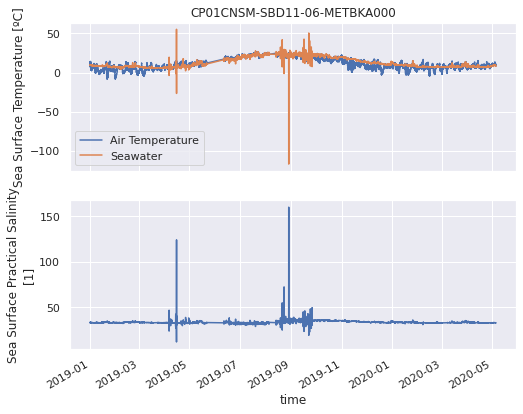

In [20]:
# Plot the data
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, figsize=(8,6))
ds.air_temperature.plot(ax=ax1,label='Air Temperature')
ds.sea_surface_temperature.plot(ax=ax1,label='Seawater')
ds.met_salsurf.plot(ax=ax2)
ax1.set_xlabel('')
ax1.legend()
ax1.set_title('CP01CNSM-SBD11-06-METBKA000');

There are a few outliers in this dataset, so let's run a quick filter.

In [0]:
import numpy as np
def reject_outliers(data, m=5):
    """
    Reject outliers beyond m standard deviations of the mean.
    :param data: numpy array containing data
    :param m: number of standard deviations from the mean. Default: 3
    """
    stdev = np.nanstd(data)
    if stdev > 0.0:
        ind = abs(data - np.nanmean(data)) < m * stdev
    else:
        ind = len(data) * [True]

    return ind


In [0]:
# Quick filter to remove outliers
ds['sea_surface_temperature'] = ds['sea_surface_temperature'].where(reject_outliers(ds['sea_surface_temperature']))
ds['met_salsurf'] = ds['met_salsurf'].where(reject_outliers(ds['met_salsurf']))

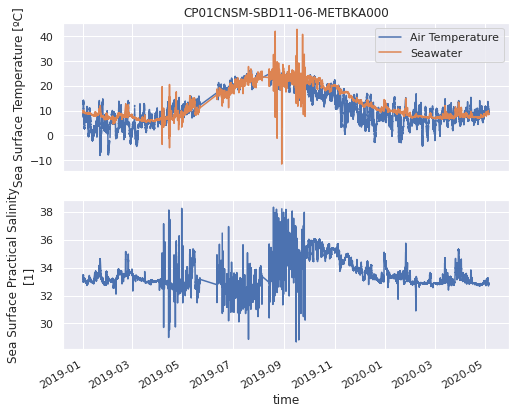

In [23]:
# Plot the data
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, figsize=(8,6))
ds.air_temperature.plot(ax=ax1,label='Air Temperature')
ds.sea_surface_temperature.plot(ax=ax1,label='Seawater')
ds.met_salsurf.plot(ax=ax2)
ax1.set_xlabel('')
ax1.legend()
ax1.set_title('CP01CNSM-SBD11-06-METBKA000');

We probably need to do some more filtering and averaging before using this dataset, but hopefully this shows you how easy it can be to request and retrieve data from the OOI - once you know what you want to grab, which is a lesson for another day.